# Stock Trades by Members of the US House of Representatives

* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    - Can you predict the party affiliation of a representative from their stock trades?
    - Can you predict the geographic region that the representative comes from using their stock trades? E.g., west coast, east coast, south, etc.
    * Can you predict whether a particular trade is a BUY or SELL?

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
TODO

### Baseline Model
TODO

### Final Model
TODO

### Fairness Evaluation
TODO

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from fuzzywuzzy import fuzz
import fuzzywuzzy.process as fwp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

/Users/marc/opt/anaconda3/envs/stock-analysis/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
def merge_parties(path_cand='./data/house_candidate.csv', path_trans='./data/all_transactions.csv'):
    data_candidates = pd.read_csv(path_cand)
    data_candidates["candidate"] = data_candidates["candidate"].str.lower()
    data_transactions = pd.read_csv(path_trans)
    data_transactions["representative"] = data_transactions["representative"]\
        .str.lower()\
        .str.replace("hon. ", "", regex=False)
    data_transactions["amount"] = data_transactions["amount"]\
        .str.replace("$", "", regex=False)\
        .str.replace(" ", "", regex=False)\
        .str.replace(",", "", regex=False)\
        .str.split("-")\
        .apply(lambda x : np.floor(pd.to_numeric(pd.Series(x), errors="coerce").mean()))
    data_transactions.loc[data_transactions["ticker"] == "--", "ticker"] = np.NaN
    choices = data_transactions["representative"].unique().tolist()
    data_candidates["representative"] = data_candidates["candidate"].apply(lambda x : fmatch(x, choices))
    data_candidates = data_candidates[["representative", "party"]].drop_duplicates().dropna()
    data_candidates = remove_duplicate_name(data_candidates)
    data_transactions = data_transactions[["transaction_date", "ticker", "type", "amount", "representative"]]\
        .drop_duplicates()
    return data_transactions.merge(data_candidates, how="left", left_on="representative", right_on="representative")

def fmatch(row, choices):
    choice = fwp.extractOne(row, choices, scorer=fuzz.token_set_ratio, score_cutoff=81)
    return np.NaN if choice is None else choice[0]

def count_names(search, list):
    return len(list[list["representative"] == search]) if not search == np.NaN else np.NaN

def remove_duplicate_name(df):
    new_df = df.copy()
    unique_names = pd.DataFrame(new_df["representative"]
                                .apply(lambda x : x if count_names(x, new_df) == 1 else np.NaN).dropna())
    return unique_names.merge(df, how="left", left_on="representative", right_on="representative", suffixes=("l", "r"))

In [3]:
data = merge_parties()
data.head(10)

,transaction_date,ticker,type,amount,representative,party
0,2021-09-27,BP,purchase,8000.0,virginia foxx,REP
1,2021-09-13,XOM,purchase,8000.0,virginia foxx,REP
2,2021-09-10,ILPT,purchase,32500.0,virginia foxx,REP
3,2021-09-28,PM,purchase,32500.0,virginia foxx,REP
4,2021-09-17,BLK,sale_partial,8000.0,alan s. lowenthal,DEM
5,2021-12-01,AXP,purchase,8000.0,aston donald mceachin,DEM
6,2021-11-30,KPLTW,purchase,8000.0,austin scott,REP
7,2021-11-18,AMD,sale_full,75000.0,thomas suozzi,DEM
8,2021-11-18,AAPL,sale_full,75000.0,thomas suozzi,DEM
9,2021-11-24,MSFT,purchase,75000.0,thomas suozzi,DEM


In [26]:
stocks = data
stocks = stocks.dropna()
stocks

X = stocks[['type', 'amount', 'transaction_date', 'ticker']]
y = stocks[["party"]]

In [7]:
len(stocks)

11135

### Baseline Model

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(stocks[['type', 'amount', 'transaction_date', 'ticker']],
                                                        stocks[['party']])

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Binarizer, FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import Nystroem

year_prefix_hotencode = Pipeline([
("get-year", FunctionTransformer(lambda x : pd.DataFrame(x["transaction_date"].str[:4]))),
("onehot", OneHotEncoder(handle_unknown='ignore')),
])

preproc = ColumnTransformer(
transformers=[
    ('amount', OneHotEncoder(handle_unknown='ignore'), ["amount", "type", "ticker"]),
    ('year', year_prefix_hotencode, ["transaction_date"])
]
)
pl = Pipeline([
('preproc', preproc),
('embedding', DecisionTreeClassifier()),
])

pl.fit(X_train, y_train["party"])
(pl.score(X_train, y_train["party"]), pl.score(X_test, y_test["party"]))

(0.9425218536702191, 0.7859195402298851)

<AxesSubplot: ylabel='Frequency'>

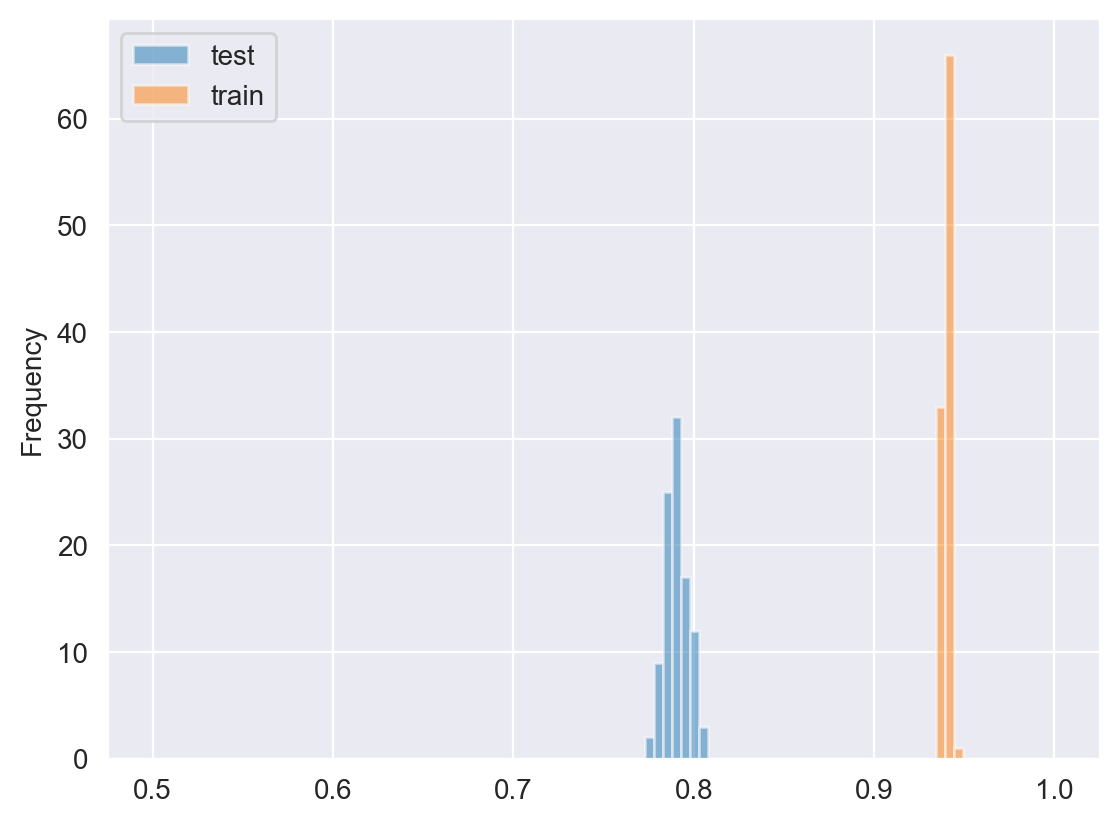

In [65]:
res = {"test":[],"train":[]}
for _ in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    pl.fit(X_train, y_train["party"])
    res["test"].append(pl.score(X_test, y_test["party"]))
    res["train"].append(pl.score(X_train, y_train["party"]))

pd.DataFrame(res).plot.hist(bins=np.linspace(0.5, 1, 100),alpha=0.5)

<AxesSubplot: xlabel='n'>

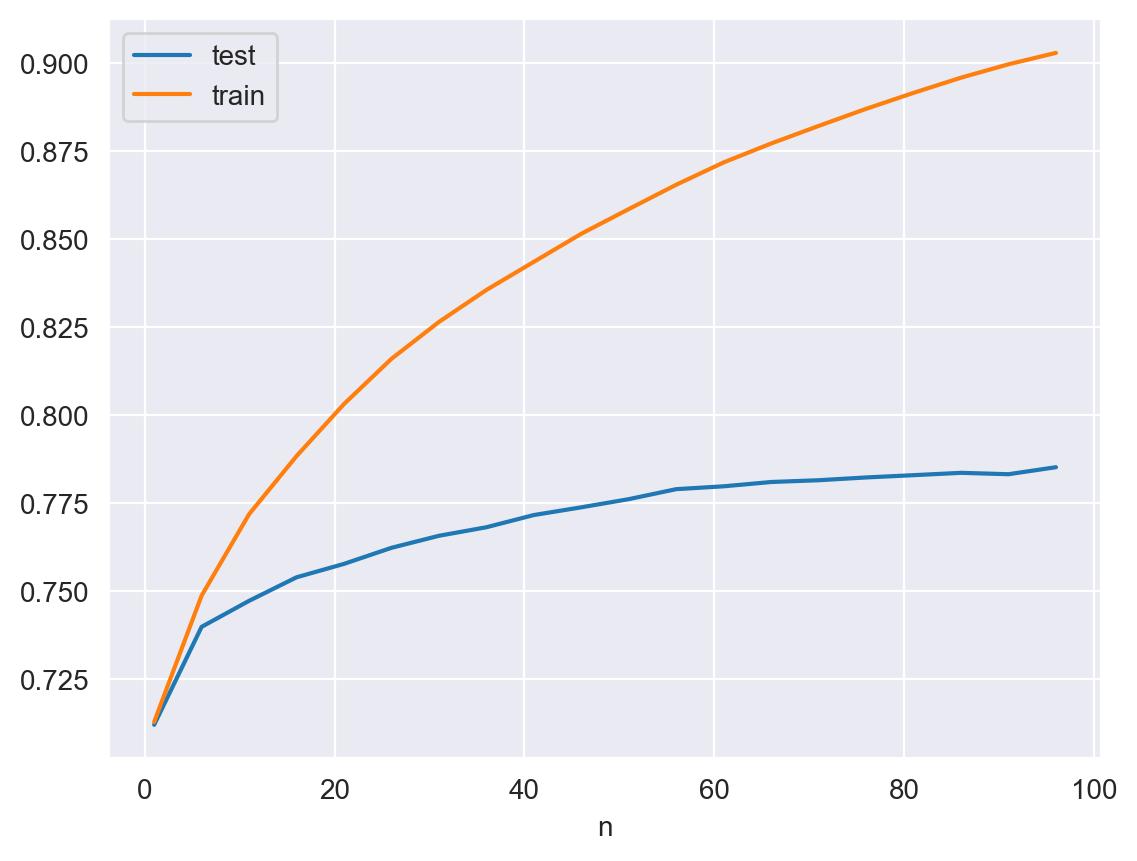

In [29]:
res = {"n":[],"test":[],"train":[]}
for n in range(1,100,5):
    pl = Pipeline([
        ('preproc', preproc),
        ('embedding', DecisionTreeClassifier(max_depth=n)),
    ])

    run = {"test":[],"train":[]}
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=i)
        pl.fit(X_train, y_train["party"])
        run["test"].append(pl.score(X_test, y_test["party"]))
        run["train"].append(pl.score(X_train, y_train["party"]))

    mns = pd.DataFrame(run).mean()
    res["n"].append(n)
    res["test"].append(mns.loc["test"])
    res["train"].append(mns.loc["train"])

df = pd.DataFrame(res)
df.set_index("n").plot()

<AxesSubplot: xlabel='n'>

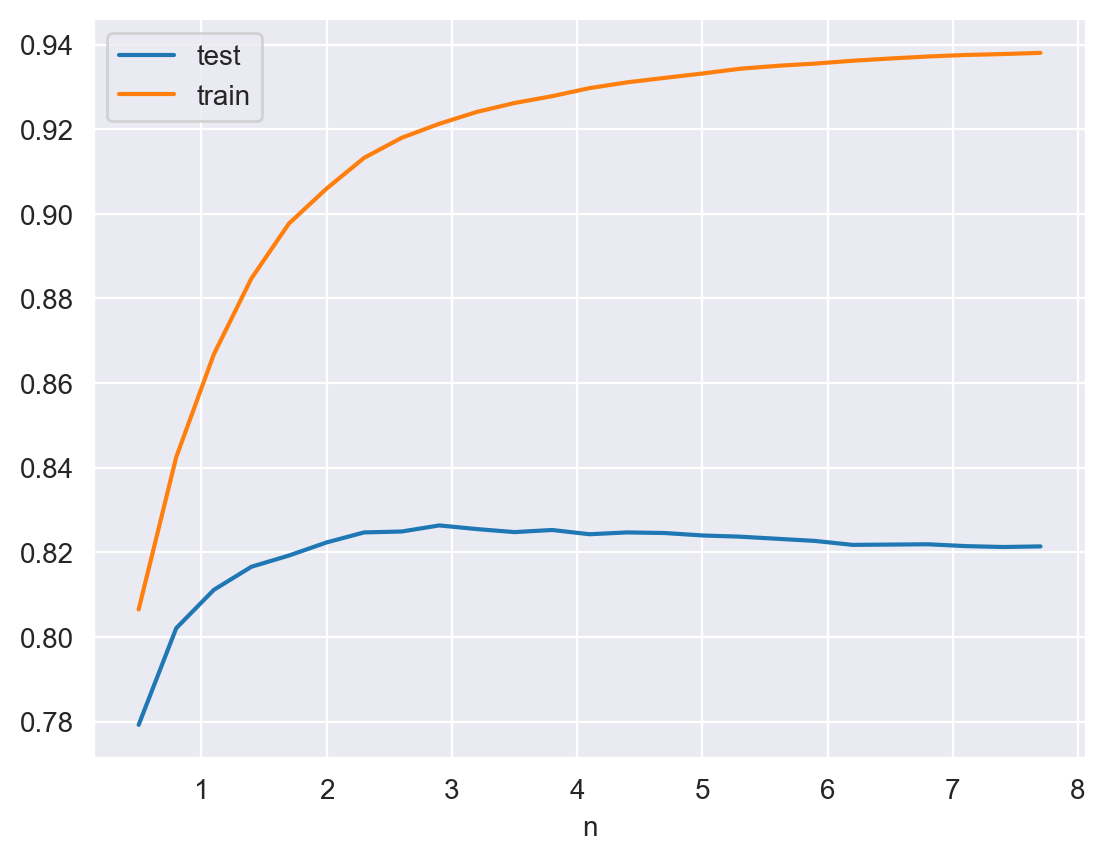

In [55]:
res = {"n":[],"test":[],"train":[]}
for n in np.arange(0.5,8,0.3):
    pl = Pipeline([
        ('preproc', preproc),
        ('embedding', SVC(C=n)),
    ])

    run = {"test":[],"train":[]}
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=i)
        pl.fit(X_train, y_train["party"])
        run["test"].append(pl.score(X_test, y_test["party"]))
        run["train"].append(pl.score(X_train, y_train["party"]))

    mns = pd.DataFrame(run).mean()
    res["n"].append(n)
    res["test"].append(mns.loc["test"])
    res["train"].append(mns.loc["train"])

df = pd.DataFrame(res)
df.set_index("n").plot()

<AxesSubplot: xlabel='n'>

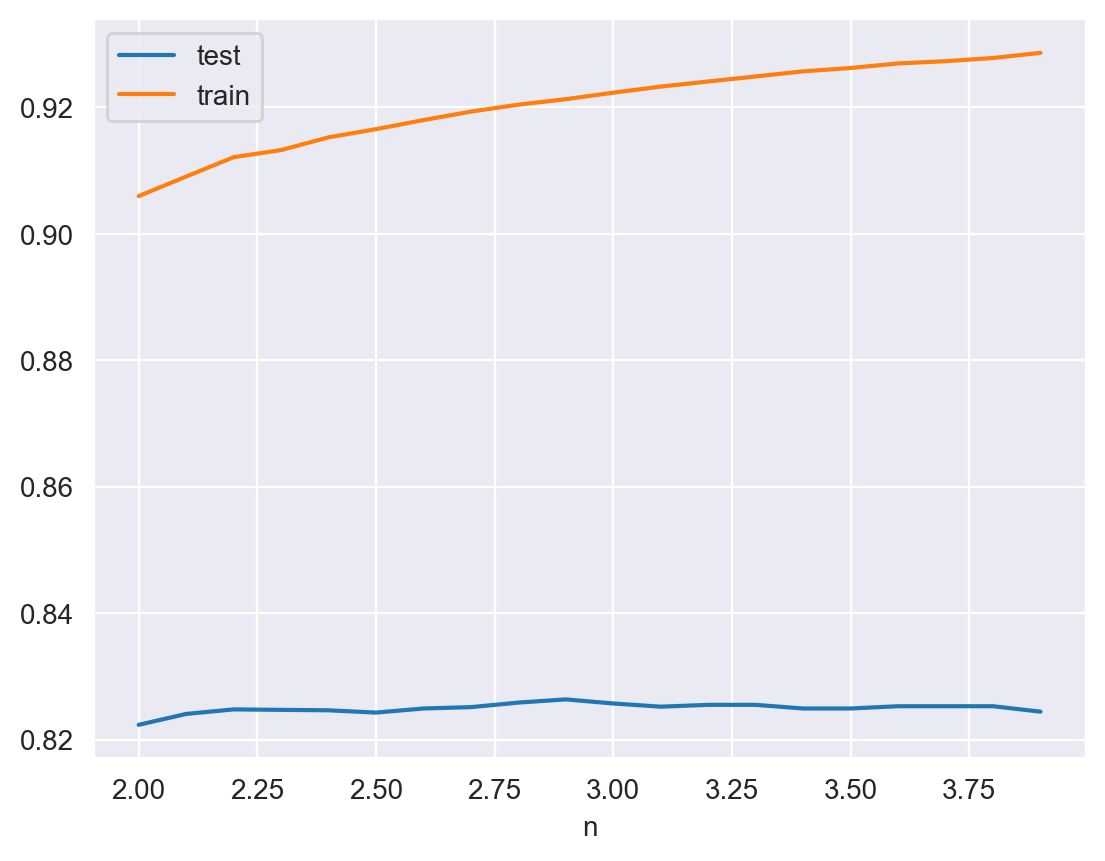

In [54]:
res = {"n":[],"test":[],"train":[]}
for n in np.arange(2,4,0.1):
    pl = Pipeline([
        ('preproc', preproc),
        ('embedding', SVC(C=n)),
    ])


    run = {"test":[],"train":[]}
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=i)
        pl.fit(X_train, y_train["party"])
        run["test"].append(pl.score(X_test, y_test["party"]))
        run["train"].append(pl.score(X_train, y_train["party"]))

    mns = pd.DataFrame(run).mean()
    res["n"].append(n)
    res["test"].append(mns.loc["test"])
    res["train"].append(mns.loc["train"])

df = pd.DataFrame(res)
df.set_index("n").plot()

<AxesSubplot: ylabel='Frequency'>

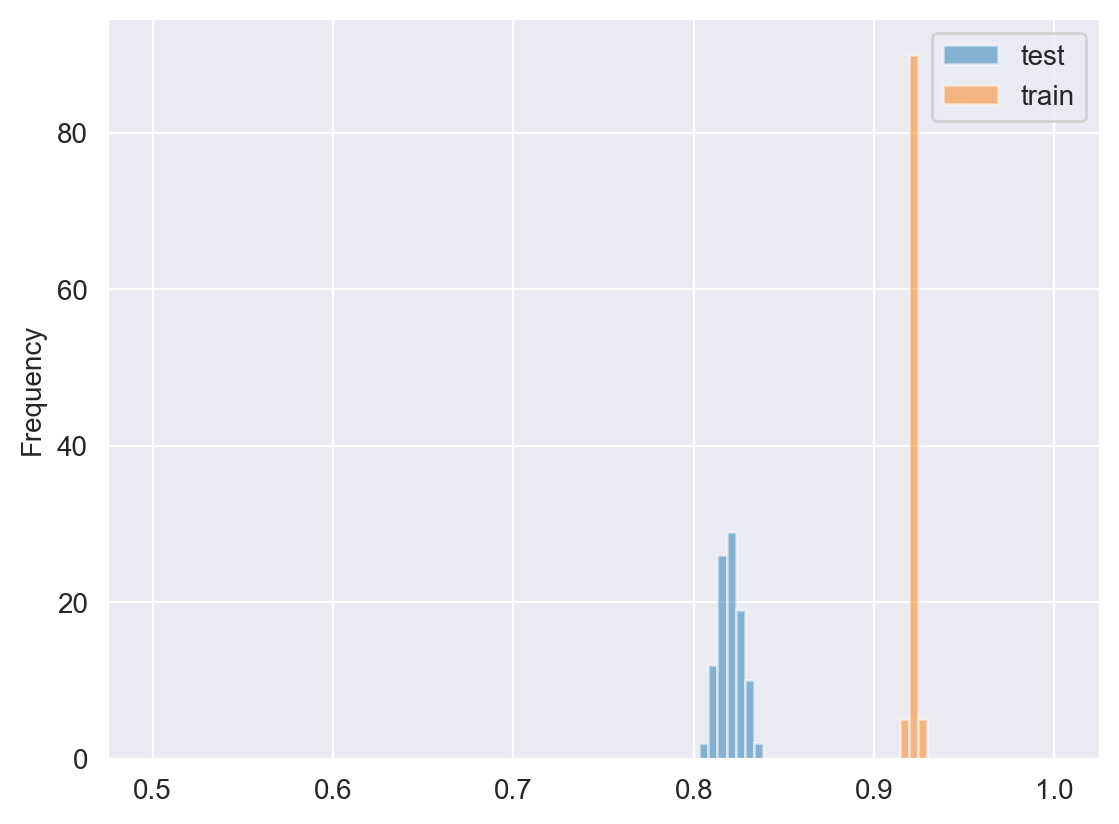

In [62]:
res = {"test":[],"train":[]}
for _ in range(100):
    pl = Pipeline([
        ('preproc', preproc),
        ('model', SVC(C=2.9)),
    ])
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    pl.fit(X_train, y_train["party"])
    res["test"].append(pl.score(X_test, y_test["party"]))
    res["train"].append(pl.score(X_train, y_train["party"]))
pd.DataFrame(res).plot.hist(bins=np.linspace(0.5, 1, 100),alpha=0.5)

In [56]:
res

{'n': [0.5,
  0.8,
  1.1,
  1.4000000000000001,
  1.7000000000000002,
  2.0,
  2.3000000000000003,
  2.6000000000000005,
  2.9000000000000004,
  3.2,
  3.5000000000000004,
  3.8000000000000007,
  4.1000000000000005,
  4.4,
  4.700000000000001,
  5.000000000000001,
  5.300000000000001,
  5.6000000000000005,
  5.9,
  6.200000000000001,
  6.500000000000001,
  6.800000000000001,
  7.100000000000001,
  7.400000000000001,
  7.700000000000001],
 'test': [0.7792385057471265,
  0.8020833333333333,
  0.8111350574712644,
  0.8165948275862069,
  0.8192528735632184,
  0.8223419540229886,
  0.824712643678161,
  0.8249281609195404,
  0.8263649425287355,
  0.8255028735632184,
  0.8247844827586206,
  0.825287356321839,
  0.8242816091954023,
  0.824712643678161,
  0.8245689655172412,
  0.8239942528735632,
  0.8237068965517242,
  0.8232040229885056,
  0.8227011494252874,
  0.8217672413793103,
  0.8218390804597702,
  0.8219109195402299,
  0.8214798850574713,
  0.8212643678160921,
  0.8214080459770114],
 '

In [ ]:
res = {"n":[],"test":[],"train":[]}
for p in np.arange(0.1,1.0,0.05):
    pl = Pipeline([
        ('preproc', preproc),
        ('embedding', SGDClassifier(C=p)),
    ])

    run = {"test":[],"train":[]}
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=i)
        pl.fit(X_train, y_train["party"])
        run["test"].append(pl.score(X_test, y_test["party"]))
        run["train"].append(pl.score(X_train, y_train["party"]))

    mns = pd.DataFrame(run).mean()
    res["n"].append(n)
    res["test"].append(mns.loc["test"])
    res["train"].append(mns.loc["train"])

df = pd.DataFrame(res)
df.set_index("n").plot()

<AxesSubplot: >

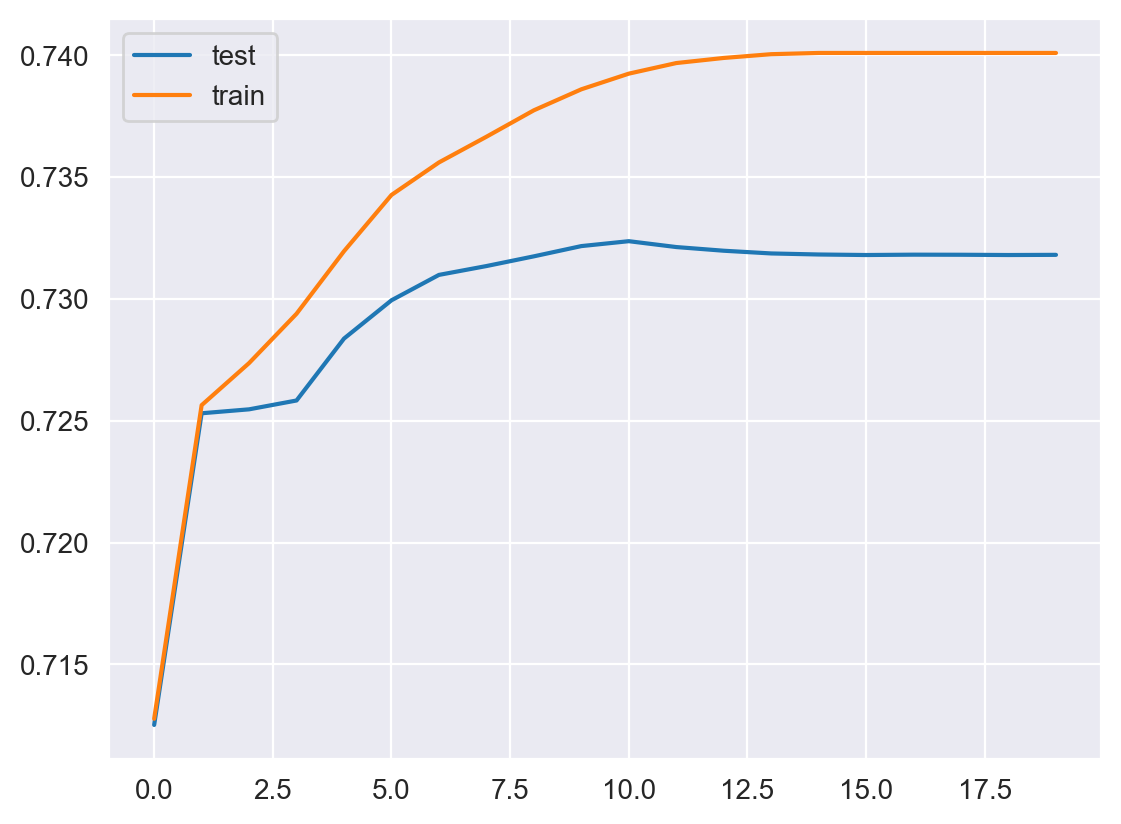

In [30]:
y_train

,party
9675,DEM
4834,REP
2477,REP
12959,NaN
12756,DEM
...,...
905,REP
5192,DEM
12172,DEM
235,DEM


### Final Model

In [ ]:
# TODO

### Fairness Evaluation

In [ ]:
# TODO